In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
import FunctionCollection as fc
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
import sympy
fc = importlib.reload(fc)
from tqdm import tqdm
from scipy.stats import norm

In [ ]:
plt.rcParams.update({'font.size': 15})

In [166]:
pred_path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions'

csv_list = [
            'OscNext_Angle_m27_23ge_test_predictions.csv',
#             'OscNext_Angle_m27_bothvMF_1qir_test_predictions.csv',
            'OscNext_Angle_m27_bothvMF2_vcqh_test_predictions.csv',
            'OscNext_Angle_m27_2xPvM_sylf_test_predictions.csv',
            'OscNext_Angle_m27_MEa_fcgf_test_predictions.csv',
            'OscNext_Angle_m27_vG2_2jnn_test_predictions.csv'
]

labels = ['SvM','SvM/2xPvM','2xPvM','MSE+MAE','vG']
colors = ['r','g','magenta','b','orange']

In [167]:
df_truth = pd.read_csv(os.path.join(pred_path,'OscNext_Angle_m27_23ge_test_predictions.csv'))[['event_no','azimuth','zenith','energy_log10','pid','elasticity']]

In [168]:
# def vec_to_angle_transform(df):
#     cos_az = np.cos(torch.tensor(df.azimuth)).unsqueeze(1)
#     sin_az = np.sin(torch.tensor(df.azimuth)).unsqueeze(1)
#     cos_ze = np.cos(torch.tensor(df.zenith)).unsqueeze(1)
#     sin_ze = np.sin(torch.tensor(df.zenith)).unsqueeze(1)
#     return torch.cat([cos_az*sin_ze, sin_az*sin_ze, cos_ze],dim=1)

def preprocess(df):
    cols = df.columns
    if 'x_pred' in cols:
        r = np.sqrt(df.x_pred**2 + df.y_pred**2 + df.z_pred**2)
#         fig, ax = plt.subplots()
#         ax.hist(r,bins=100)
        df['azimuth_pred'] = np.arctan2(df.y_pred,df.x_pred)
        df['zenith_pred'] = np.arccos(df.z_pred/r)
    if 'k_solid' in cols:
        kappa = df.k_solid**2 + 1e-5
        df['solid_sigma'] = np.sqrt(-2*np.log((1 + np.exp(-2*kappa))/(1 - np.exp(-2*kappa)) - 1/kappa))
    if 'k_az' in cols:
        from scipy.special import iv
        kappa =  df.k_az**2 + 1e-5
        df['azimuth_sigma'] = np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))
    if 'k_ze' in cols:
        from scipy.special import iv
        kappa =  df.k_ze**2 + 1e-5
        df['zenith_sigma'] = np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))
    if 'pred_sigma' in  cols:
        df.rename(columns={'pred_sigma':'solid_sigma'},inplace=True)
    if 'solid' not in cols:
        def Omega(azp,zep,azt,zet):
            s1 = np.sin( zet + azt - azp )
            s2 = np.sin( zet - azt + azp )
            c1 = np.cos( zet - zep )
            c2 = np.cos( zet + zep )
            return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))
        df['solid'] = Omega(df.azimuth_pred,df.zenith_pred,df_truth.azimuth,df_truth.zenith)
    cols = df.columns
    return df.iloc[:,cols.isin(['solid','azimuth_pred','zenith_pred','solid_sigma','azimuth_sigma','zenith_sigma'])]

In [169]:
df_dict = dict()
for csv, label in tqdm(zip(csv_list,labels)):
    df_dict[label] = preprocess(pd.read_csv(os.path.join(pred_path,csv)))

5it [00:28,  5.72s/it]


Checking whether csv's that doesn't have event_no have the right ordering


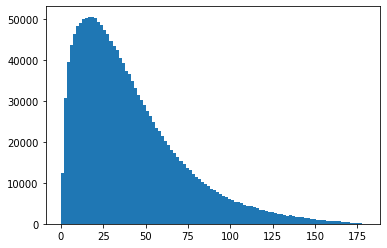

In [121]:
print("Checking whether csv's that doesn't have event_no have the right ordering")
fig, ax = plt.subplots()
# ax.hist2d(df_list[1].zenith_pred,df_list[2].zenith_pred,bins=100);
ax.hist2d(df_list[1].solid,df_list[2].solid,bins=100);
# ax.hist2d(df_truth.azimuth,df_list[-1].azimuth_pred,bins=100);
# ax.hist(df_list[-1].solid*180/np.pi,bins=100);

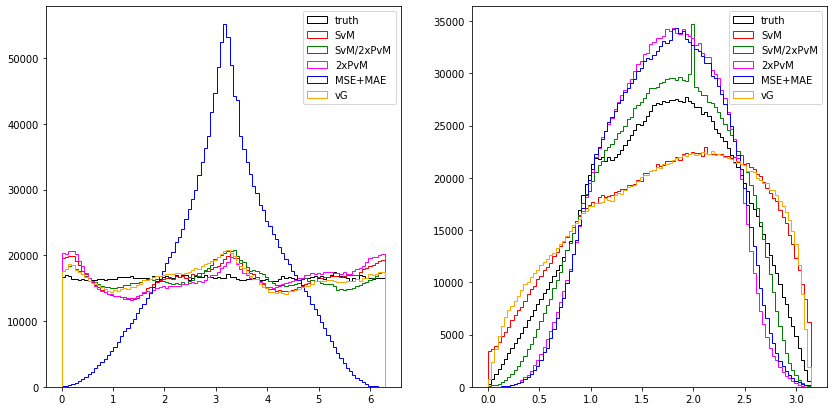

In [172]:
fig, ax = plt.subplots(figsize=(14,7),ncols=2)
ax[0].hist(df_truth.azimuth,bins=100,range=(0,2*np.pi),label='truth',color='k',histtype='step');
ax[1].hist(df_truth.zenith,bins=100,range=(0,np.pi),label='truth',color='k',histtype='step');


for x, label, color in zip([df.azimuth_pred for df in df_dict.values()],labels,colors):
    ax[0].hist(x%(2*np.pi),bins=100,range=(0,2*np.pi),label=label,color=color,histtype='step');
    
for x, label, color in zip([df.zenith_pred for df in df_dict.values()],labels,colors):
    ax[1].hist(np.abs(x),bins=100,range=(0,np.pi),label=label,color=color,histtype='step');

ax[0].legend()
ax[1].legend()

In [212]:
def plot_quantiles(res, x, bins, qs, ax, label, color,offset):
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xes = np.zeros(bins)
    
    for i in range(bins):
        mask = (x >= slices[i])&(x <= slices[i+1])
        quantiles[i] = np.quantile(res[mask],qs)
        xes[i] = np.mean(x[mask])
    
    xes += offset
    
    ax.errorbar(x = xes, y = quantiles[:,1], yerr = abs(quantiles[:,1] - quantiles[:,[0,2]].T),
                color=color,
                linewidth=5,
                alpha=0.5,
                capsize=5,
                linestyle='--',
                fmt='none')
    
    ax.plot(xes,quantiles[:,1],c=color,marker='*',label=label)
#     plt.grid()
    
    ax_hist = ax.twinx()
    val, binedges, _ = ax_hist.hist(x,bins=bins,histtype='step',color='grey',linewidth=5)
    ax_hist.vlines(xes-offset,val+0.1*val.mean(),val-0.1*val.mean(),color='grey',label='mean')
    ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
    ax_hist.set_ylabel("N")
#     ax_hist.set_yscale('log')
    ax.set_zorder(ax_hist.get_zorder()+1)
    ax.patch.set_visible(False)
    
#     fig.show()

Text(0, 0.5, '$16^{th}$-$50^{th}$-$68^{th}$ percentile of the solid angle $[deg]$')

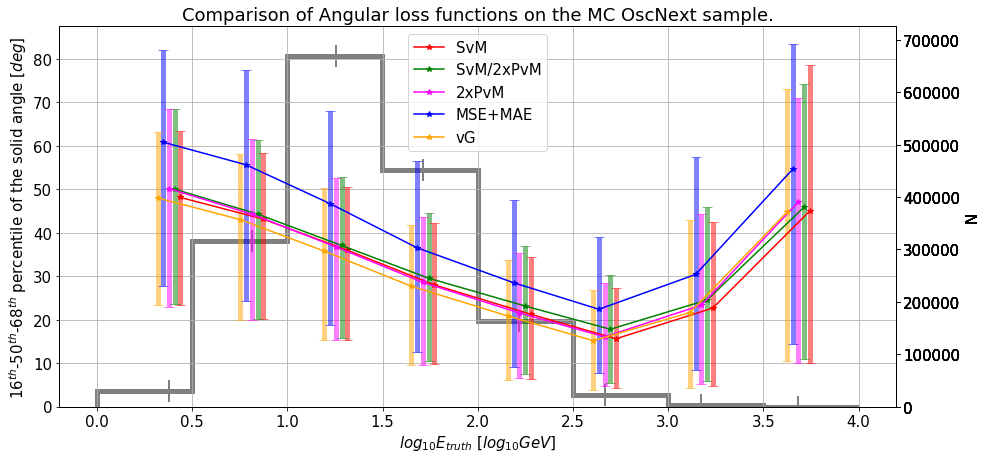

In [213]:
fig, ax = plt.subplots(figsize=(15,7))
# plt.yscale('log')
plt.grid()

for i, (x, label, color) in enumerate(zip([df.solid for df in df_dict.values()],labels,colors)):
    offset = 0.03*(len(df_list)/2 - i - 0.5)
    plot_quantiles(x*180/np.pi,df_truth.energy_log10,8,[0.16,0.5,0.68],ax,label,color,offset)

ax.legend()
ax.set_title("Comparison of Angular loss functions on the MC OscNext sample.")
ax.set_xlabel("$log_{10}E_{truth}$ $[log_{10}GeV]$")
ax.set_ylabel("$16^{th}$-$50^{th}$-$68^{th}$ percentile of the solid angle $[deg]$")

In [214]:
# fig.savefig("plots/angular_loss_comparison.pdf")

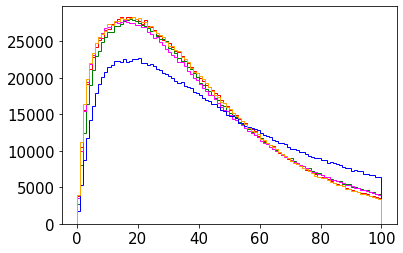

In [215]:
fig, ax = plt.subplots()

for i, (x, label, color) in enumerate(zip([df.solid for df in df_dict.values()],labels,colors)):
    ax.hist(x*180/np.pi,bins=100,range=(0,100),histtype='step',color=color,label=label);
# ax.set_xscale('log')

In [231]:
color_dict = dict(zip(labels,colors))

C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


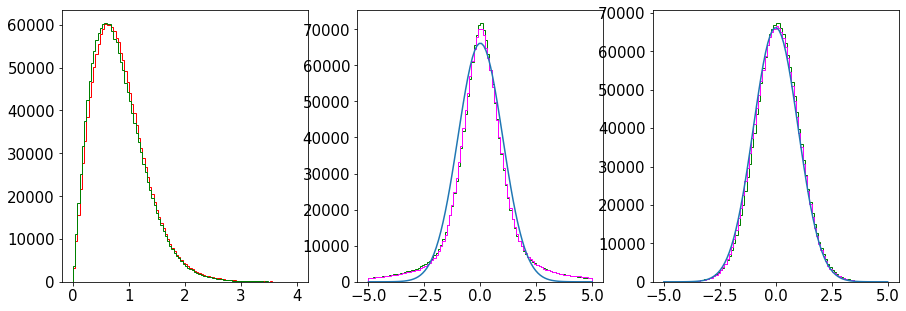

In [248]:
def plot_Z(res,sig,ax,bins,range,label,color):
    ax.hist(res/sig,bins=bins,range=range,label=label,color=color,histtype='step')

fig, ax = plt.subplots(figsize=(15,5),ncols=3)

for key in ['SvM','SvM/2xPvM']:
    df = df_dict[key]
    plot_Z(df.solid,df.solid_sigma,ax[0],100,(0,4),key,color_dict[key])
    

for key in ['SvM/2xPvM','2xPvM']:
    df = df_dict[key]
    plot_Z((df.azimuth_pred%(2*np.pi) - df_truth.azimuth),df.azimuth_sigma,ax[1],100,(-5,5),key,color_dict[key])
    plot_Z((df.zenith_pred.abs() - df_truth.zenith),df.zenith_sigma,ax[2],100,(-5,5),key,color_dict[key])

ax[1].plot(np.linspace(-5,5,100),norm.pdf(np.linspace(-5,5,100))*df_truth.__len__()/10)
ax[2].plot(np.linspace(-5,5,100),norm.pdf(np.linspace(-5,5,100))*df_truth.__len__()/10)